In [16]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import random
rng = np.random.default_rng()
sn.set_style('whitegrid')

In [17]:
#import and create cleaned stimuli strings which can be copied directly into GPT if desired
#find difference score between human ratings (Graves 2013) and GPTv3.5 (March 14)

home_direct = 'C:/Users/Nick/Downloads/meat-kangaroo-main/'

all_words_and_measures = pd.read_csv(home_direct + 'graves_with_vecs.csv', skipinitialspace=True, )

all_words_and_measures['Humans Binary'] = np.where(
    all_words_and_measures['Humans Continuous'] >= 2.5, 'Makes Sense', np.where(
    all_words_and_measures['Humans Continuous'] <= 1.5, 'Nonsense', 'Ambiguous'))

#all_words_and_measures['Stim'] = 'the ' + all_words_and_measures['Stim'].str.replace('-', ' ') + '.'
all_words_and_measures['Difference Score'] = abs(all_words_and_measures['Humans Continuous'] - all_words_and_measures['GPT Continuous Temp 0'])

# all_words_and_measures.to_excel('cleaned_words.xlsx')

In [19]:
remove_middle = all_words_and_measures[all_words_and_measures['Humans Binary'].isin(['Makes Sense', 'Nonsense'])]
remove_middle

,Stim,Bard,Bard 0 or 1,GPT Temp 0,GPT Temp .5,GPT Temp 1,GPT Continuous Temp 0,GPT Continuous Temp .5,GPT Continuous Temp 1,Class,...,Wordfrq_sum,Logw1frq,Logw2frq,Logwordfrq_sum,pairs,Word2Vec,GloVe,Taxonomic,Humans Binary,Difference Score
0,the alcohol blood.,Nonsense,0,Nonsense,Nonsense,Nonsense,2,2,2,-1,...,2860,2.51,3.40,5.91,alcohol blood,0.371276,0.402202,0.570252,Nonsense,1.29
1,the alcohol screen.,Nonsense,0,Makes Sense,Makes Sense,Makes Sense,2,2,2,1,...,842,2.51,2.71,5.22,alcohol screen,0.066408,0.079153,0.174365,Nonsense,1.10
2,the alligator mouth.,Makes Sense,1,Makes Sense,Makes Sense,Nonsense,3,2,3,1,...,2435,1.38,3.38,4.76,alligator mouth,0.212631,0.283078,0.205588,Makes Sense,0.54
3,the alligator skin.,Nonsense,0,Makes Sense,Makes Sense,Makes Sense,3,3,3,1,...,1641,1.38,3.21,4.59,alligator skin,0.150999,0.284452,0.227702,Makes Sense,0.93
4,the ankle bracelet.,Nonsense,0,Makes Sense,Makes Sense,Makes Sense,4,3,3,1,...,250,2.27,1.81,4.08,ankle bracelet,0.158441,0.392702,0.263679,Makes Sense,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,the woman judge.,Makes Sense,1,Makes Sense,Makes Sense,Makes Sense,3,2,3,1,...,7060,3.78,2.99,6.78,woman judge,0.279547,0.290409,0.280588,Makes Sense,0.64
2153,the woman mountain.,Nonsense,0,Nonsense,Nonsense,Nonsense,2,2,2,-1,...,6901,3.78,2.92,6.70,woman mountain,0.117146,0.187664,0.175159,Nonsense,1.57
2155,the worm farmer.,Nonsense,0,Makes Sense,Makes Sense,Makes Sense,3,3,3,1,...,695,2.12,2.75,4.87,worm farmer,0.118636,0.056309,0.270838,Makes Sense,0.50
2156,the yarn ball.,Nonsense,0,Makes Sense,Makes Sense,Makes Sense,3,3,3,-1,...,1688,1.38,3.22,4.60,yarn ball,0.093765,0.204294,0.390770,Makes Sense,0.59


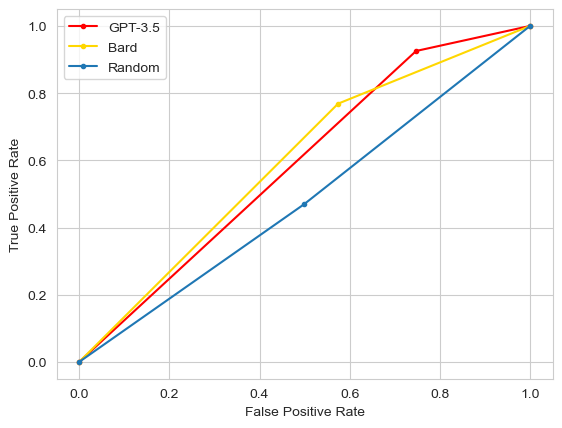

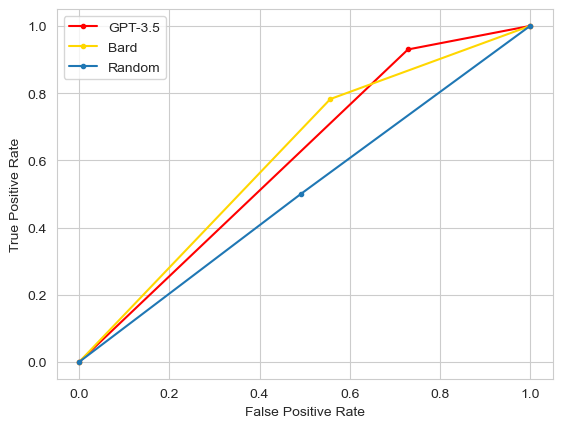

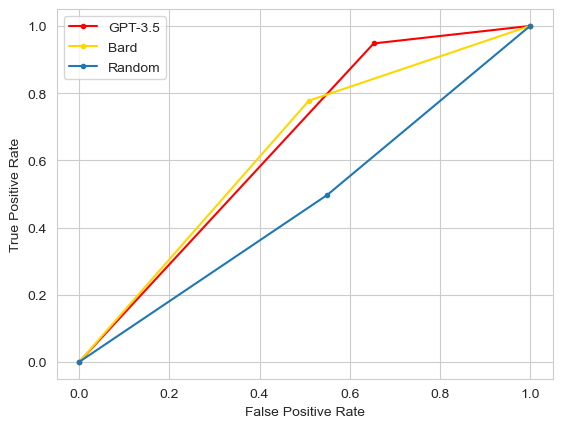

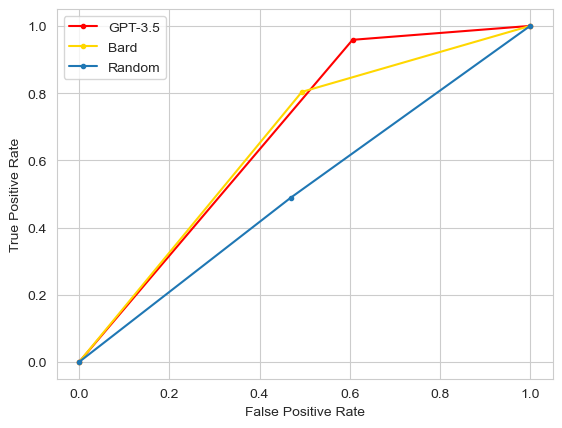

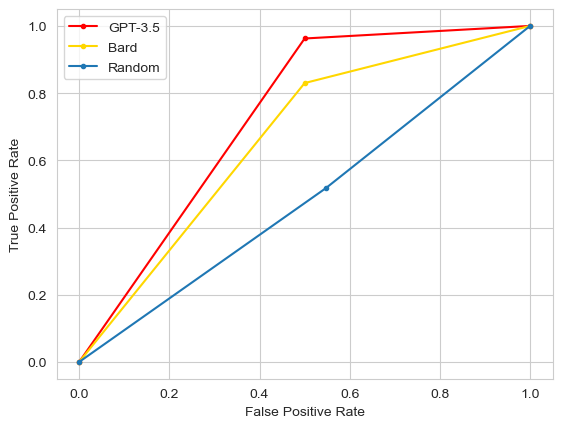

In [27]:
SD = [0,1,1.65,2.32,3.09]

for dev in SD:
    sensible_SD = remove_middle[(remove_middle['Humans Continuous'] >= 2.5) & (remove_middle['Humans Continuous'] - (dev * remove_middle['SD']) >= 1.5)]
    nonsensible_SD = remove_middle[(remove_middle['Humans Continuous'] <= 1.5) & (remove_middle['Humans Continuous'] + (dev * remove_middle['SD']) <= 2.5)]

    remove_by_SD = pd.concat([sensible_SD, nonsensible_SD])
    

    binary_for_ROC = [
    (remove_by_SD['Humans Binary'] == 'Nonsense'),
    (remove_by_SD['Humans Binary'] == 'Makes Sense')
    ]

    binary_for_GPT = [
    (remove_by_SD['GPT Temp 1'] == 'Nonsense'),
    (remove_by_SD['GPT Temp 1'] == 'Makes Sense')
    ]

    binary_for_bard = [
    (remove_by_SD['Bard'] == 'Nonsense'),
    (remove_by_SD['Bard'] == 'Makes Sense')
    ]

    labels_for_ROC = [0, 1]

    remove_by_SD['Truth'] = np.select(binary_for_ROC, labels_for_ROC)
    remove_by_SD['GPT Predicted'] = np.select(binary_for_GPT, labels_for_ROC)
    remove_by_SD['Bard Predicted'] = np.select(binary_for_bard, labels_for_ROC)
    remove_by_SD['Random'] = np.random.randint(0,2,size=len(remove_by_SD))

    truth = remove_by_SD['Truth'].to_numpy()
    gpt_predicted = remove_by_SD['GPT Predicted'].to_numpy()
    bard_predicted = remove_by_SD['Bard Predicted'].to_numpy()
    random = remove_by_SD['Random'].to_numpy()
    
    gpt_fpr, gpt_tpr, thresholds = roc_curve(truth, gpt_predicted, pos_label=1)
    bard_fpr, bard_tpr, thresholds = roc_curve(truth, bard_predicted, pos_label=1)
    rand_fpr, rand_tpr, thresholds = roc_curve(truth, random, pos_label=1)

    pyplot.plot(gpt_fpr, gpt_tpr, marker='.', label='GPT-3.5', color='red')
    pyplot.plot(bard_fpr, bard_tpr, marker='.', label='Bard', color='gold')
    pyplot.plot(rand_fpr, rand_tpr, marker='.', label='Random')
    # plot the roc curve for the model
    pyplot.legend()
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.show()